In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

DATA_DIR = '/Users/marina/Documents/PhD/research/astro_research/code/dist_code/data/'


In [ ]:
    # keys are:
    # obj_id:                         light curve id
    # true_z, photo_z:                transient redshift and host photo-z

    # These columns are calculated for each band (* = u, g, r, i, z, y)

    # *_first_mjd:                    epoch of initial detection ('first epoch')
    # *_first_snr:                    first-epoch SNR
    # *_min_snr, *_max_snr:           minimal and maximal SNR of the light curve
    # *_first_mag, *_first_mag_err:   first-epoch magnitude and error
    # *_min_mag, *_min_mag_err:       faintest magnitude and error
    # *_max_mag, *_max_mag_err:       peak or brighest magnitude and error
    # *_first_flux, *_first_flux_err: first-epoch physical flux and error
    # *_min_flux, *_min_flux_err:     minimal flux (matching faintest magnitude)
    # *_max_flux, *_max_flux_err:     maximal flux (matching peak magnitude)

In [37]:

# Get samples from this class with this feature range

def get_data(name):
    """
    Pull down project data, one of two types:
    all-features-dataset: 'all_features'
    g_W2-dataset: 'g_W2'
    """
    X = pd.read_csv(DATA_DIR + name + '_X.csv')
    X.drop(['Unnamed: 0'], axis=1, inplace=True)
    y = pd.read_csv(DATA_DIR + name + '_y.csv')
    y.drop(['Unnamed: 0'], axis=1, inplace=True)
    df = pd.concat([X, y], axis=1)
    return df
    
    

TARGET_LABEL = 'transient_type'
def convert_str_to_list(input_string):
    """
    Convert string to list
    """
    l = input_string.split(",")
    return [item.strip(' ') for item in l]

def get_thex_class_redshifts(class_name, data):
    keep_indices = []
    for index, row in data.iterrows():
        labels = convert_str_to_list(row[TARGET_LABEL])
        if class_name in labels:
            keep_indices.append(index)

    return data.loc[keep_indices, :]['redshift'].values

def get_thex_class_count(class_name, data):
    
    keep_indices = []
    for index, row in data.iterrows():
        labels = convert_str_to_list(row[TARGET_LABEL])
        if class_name in labels:
            keep_indices.append(index)

    return data.loc[keep_indices, :].reset_index(drop=True)

def filter_class_feature_range(class_name, feature_name, min_feature, max_feature, data):
    """
    Get redshift values for data filtered on this range:
    Filter data to those with class value and feature in range. 
    :param class_name: class name to filter on
    :param feature_name: Name of feature to filter on
    :param min_feature: Minimum feature value to keep
    :param max_feature: Maximum feature value to keep
    :param data: Pandas DataFrame from model 
    """

    keep_indices = []
    for index, row in data.iterrows():
        labels = convert_str_to_list(row[TARGET_LABEL])
        in_range = row[feature_name] >= min_feature and row[feature_name] <= max_feature
        if class_name in labels and in_range:
            keep_indices.append(index)

    filt_df = data.loc[keep_indices, :].reset_index(drop=True)
    
    return filt_df['redshift'].values

def filter_lsst_data(class_name, feature_name, min_feature, max_feature, data):
    """
    Get redshift values for data filtered on this range: label class_name
    whose  feature values are in the range [min_feature,max_feature ] 
    :param data: loaded pickle of lsst-sims.pk
    """
    class_data = data[class_name]
    
    feature_vals = class_data[feature_name]
    indices = np.where((feature_vals>=min_feature) & (feature_vals<=max_feature))[0]
    
    class_data_Z = class_data['true_z']
    class_data_filt = np.take(class_data_Z, indices)
    
    return class_data_filt




def plot_redshift_compare(thex_data, lsst_data, thex_data_filt, lsst_data_filt, labels):
    """
    Plot redshift distributions of the subset of data for
    THEx vs LSST
    """
    FIG_WIDTH = 6
    FIG_HEIGHT = 4
    DPI = 600
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT),
                            dpi=DPI, 
                           tight_layout=True,
                          sharex= True,
                          sharey= True)

    min_val = min(thex_data.min(), lsst_data.min())
    max_val = 1 # max(thex_data.max(), lsst_data.max())
    
    num_bins  = 200
    ax.hist(thex_data, 
            range=(min_val, max_val), 
            bins=num_bins,
            histtype='step',
            linewidth = 0.8,
            density=True, 
            label=labels[0])
    ax.hist(lsst_data, 
            range=(min_val, max_val), 
            bins=num_bins,
            histtype='step',
            linewidth = 0.8,
            density=True, 
            label=labels[1])
        
    ax.hist(thex_data_filt, 
            range=(min_val, max_val), 
            bins=num_bins,
            histtype='step',
            linewidth = 1.2,
            density=True, 
            label=labels[2])
    ax.hist(lsst_data_filt, 
            range=(min_val, max_val), 
            bins=num_bins,
            histtype='step', 
            linewidth = 1.2,
            density=True, 
            label=labels[3])

    ax.set_xlim(min_val, max_val)
    plt.legend()
    plt.xlabel("Redshift", fontsize=10)
    plt.savefig("../figures/Redshift_overlap.png")
    plt.show()

In [5]:
# # Overlay plot with redshift distribution of database 
# def get_attributes(data_file, rowmask_file):
#     """
#     Uses redshift and labels & returns redshifts, valid redshifts, and idxf
#     idxf is  map from each class name to  a list that is the same length as the number of samples in the dataset. for each one, it is True or False, based on whether that sample contains that label.
#     """
#     data = np.load(DATA_DIR + data_file, allow_pickle=True)
#     rowmask = np.load(DATA_DIR + rowmask_file, allow_pickle=True)
#     z = data['redshift']
#     valid_z = np.isfinite(z)
#     idxf = {r: rowmask[r] == 1 for r in list(rowmask.dtype.names)}
#     return z, valid_z, idxf
# allmags_zred, allmags_valid_z, allmags_idxf = get_attributes(
#         data_file='allmags_data.npy',
#         rowmask_file='allmags_rowmask.npy')

In [7]:

# Pull down data

with open(DATA_DIR + 'lsst-sims.pk', 'rb') as f:
    lc_prop = pickle.load(f)
    

df = get_data(name='all_features')

Proportion of THEx data kept for class Ia : 0.76


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in less_equal


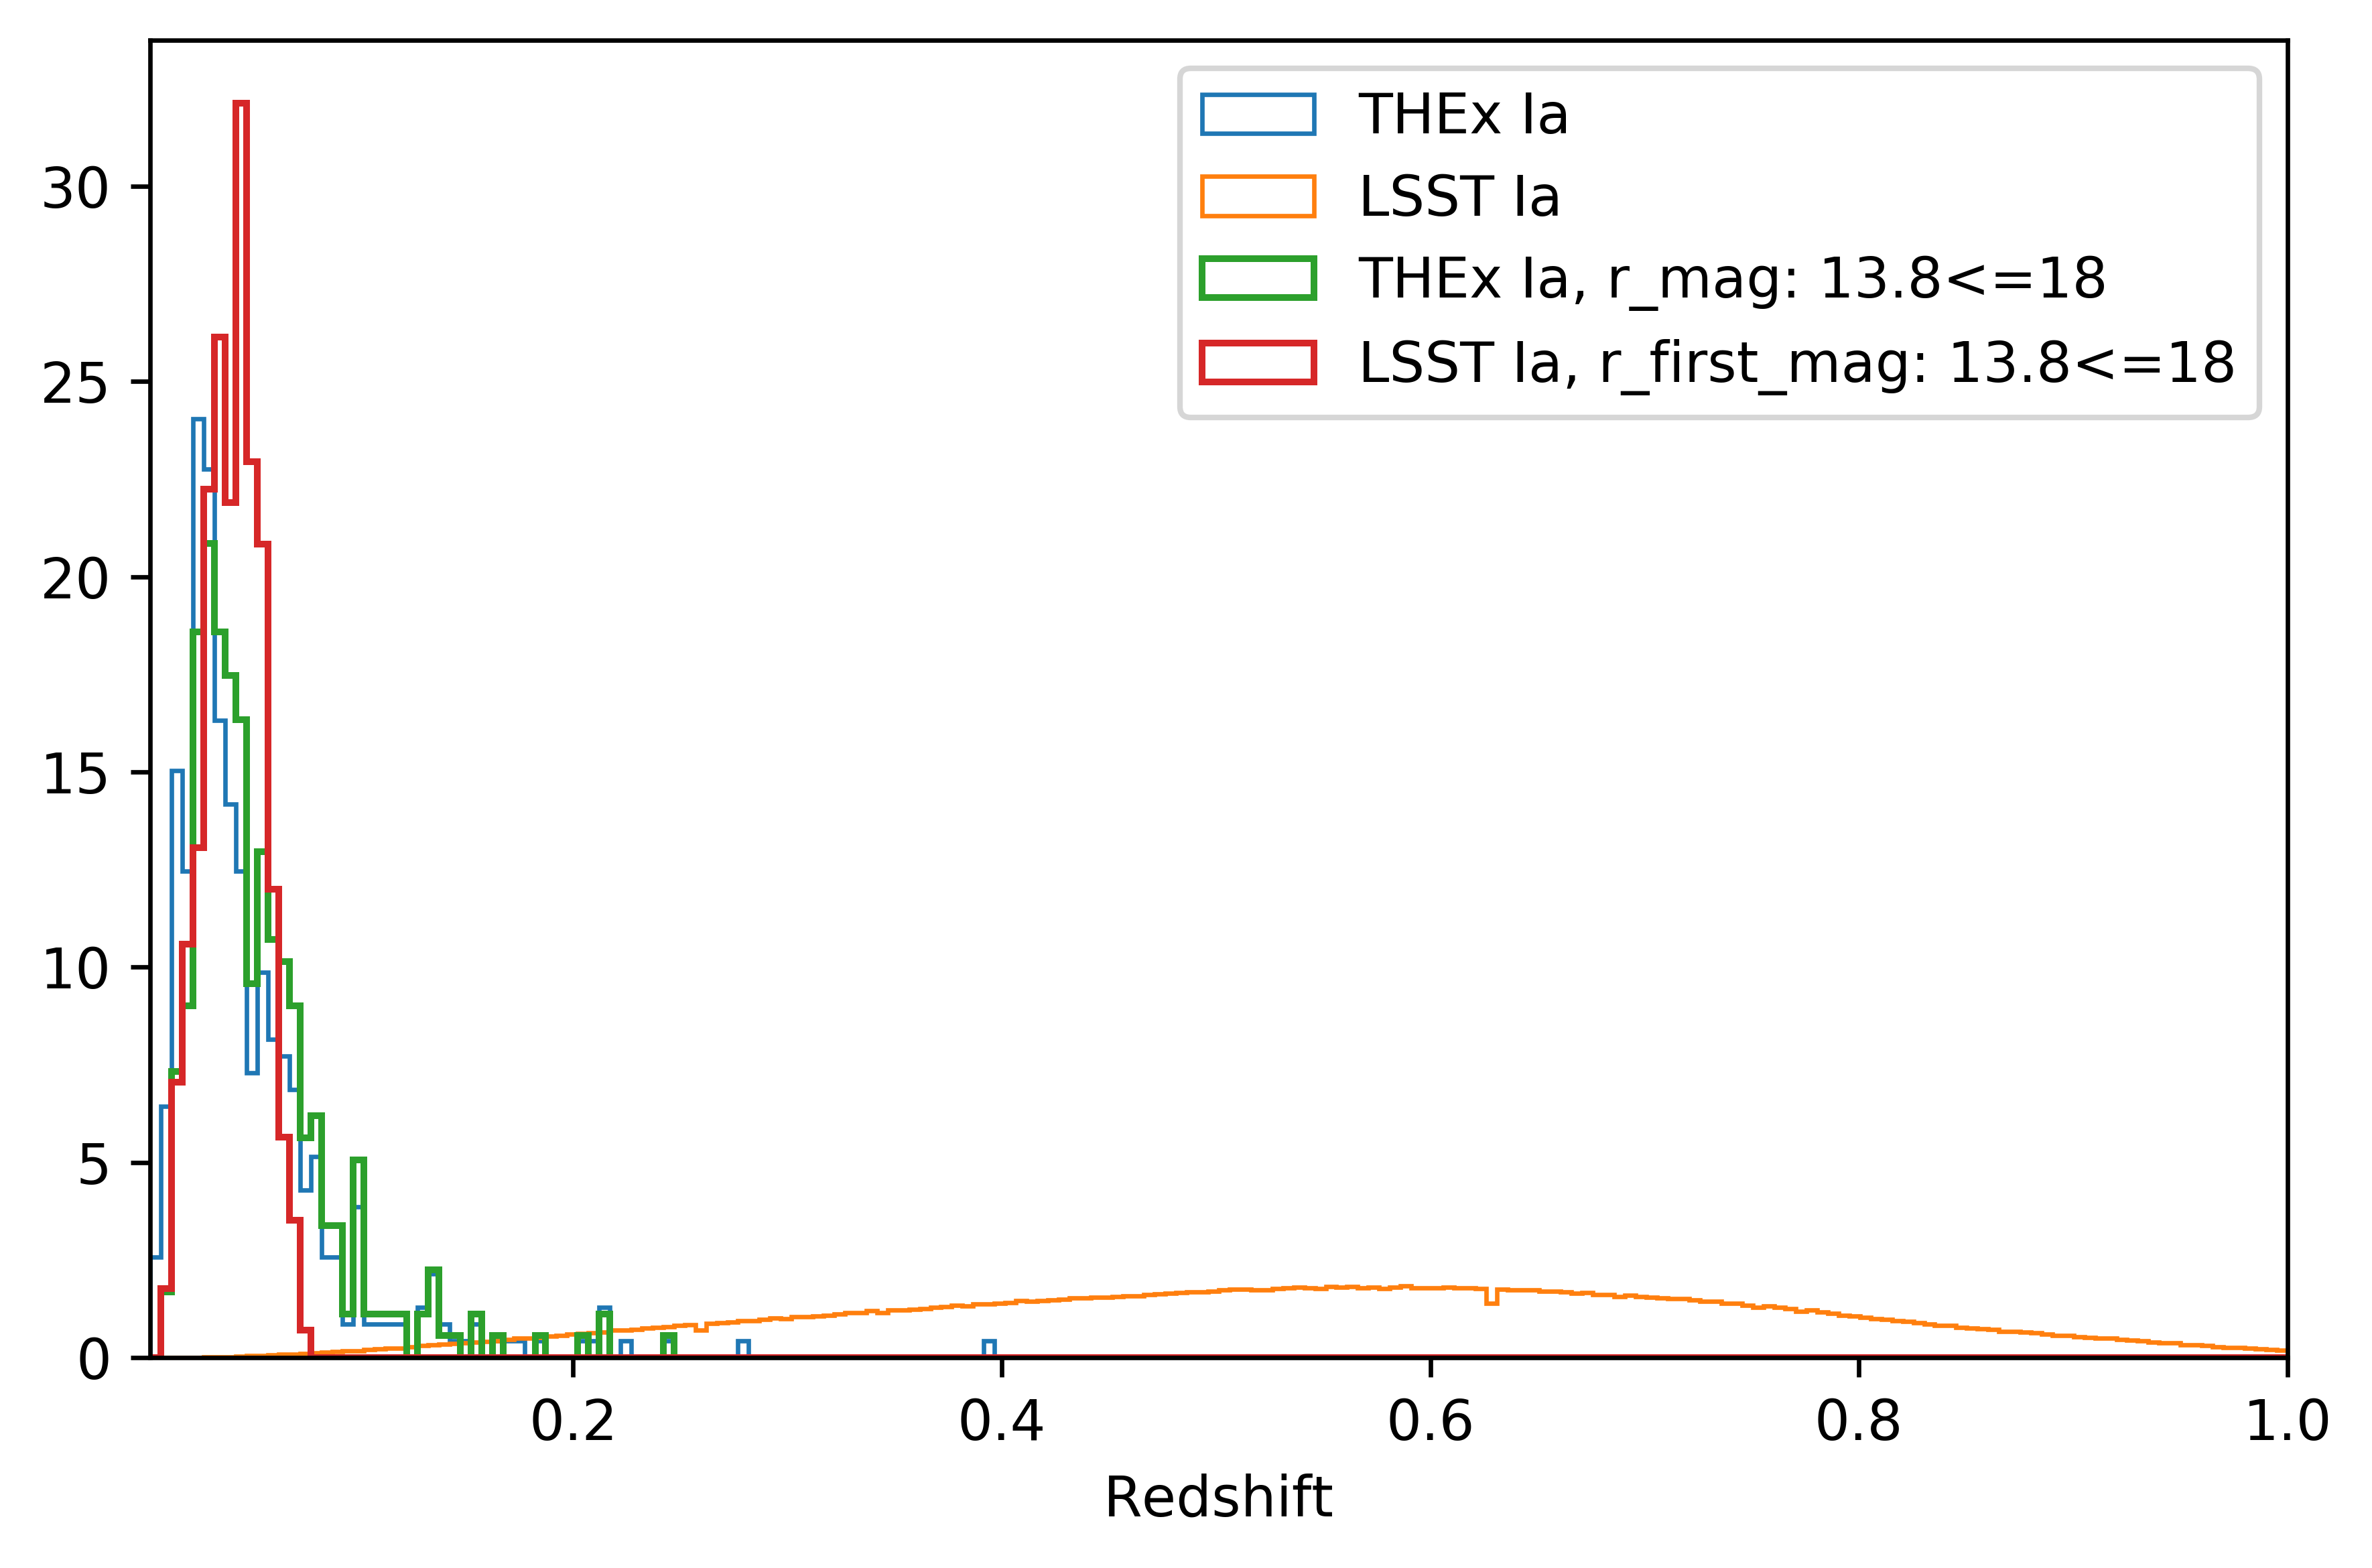

In [38]:

# r ranges from 10-20
min_range = 13.8
max_range = 18
class_name =  "Ia"
feature_name ='r_mag'
lsst_feature_name = 'r_first_mag'




thex_data_filt = filter_class_feature_range(class_name=class_name,
                                    feature_name = feature_name,
                                    min_feature=min_range, 
                                    max_feature=max_range,
                                    data = df)
old_count = get_thex_class_count(class_name, df).shape[0]
new_count = thex_data_filt.shape[0]

r = round(new_count/old_count, 2)
print("Proportion of THEx data kept for class " + class_name + " : " + str(r))


lsst_data_filt = filter_lsst_data(class_name=class_name, 
                 feature_name=lsst_feature_name, 
                 min_feature=min_range, 
                 max_feature=max_range, 
                 data=lc_prop)


thex_orig_label = "THEx " + class_name  
lsst_orig_label = "LSST " + class_name 
thex_data_orig = get_thex_class_redshifts(class_name, df)
 
lsst_data_orig =  lc_prop[class_name]["true_z"]
lsst_data_orig = lsst_data_orig[~np.isnan(lsst_data_orig)]

thex_filt_label = "THEx " + class_name + ", " + feature_name + ": " + str(min_range)+ "<=" + str(max_range) 
lsst_filt_label = "LSST " + class_name + ", " + lsst_feature_name + ": " + str(min_range)+ "<=" + str(max_range) 


labels = [thex_orig_label, lsst_orig_label,  thex_filt_label, lsst_filt_label]
plot_redshift_compare(thex_data_orig, lsst_data_orig, thex_data_filt, 
                      lsst_data_filt, 
                      labels = labels)



